# Project

Following are the meaning of each of those constants:
 - PLOT_TIME: if the plots are aimed to compare algorithms using time as X-axis
 - EPOCHS: max number of epochs, to be set to 999999999 if the aim is to compare algorithms based on time
 - MAX_RUNTIME: max number of seconds allowed to each algorithm, to be set to 999999999 if the aim is to compare algorithms based on iterations
 - ITERS_PER_BATCH: number of iteration of the algorithms on each minibatch
 - MINI_BATCH_SIZE: size of each minibatch (last |training set| % MINI_BATCH_SIZE will be discarded)
 - SAME_MINI_BATCH: if the algorithms will use the same randomly craeted minibatch
 - DPI_PLOTS: size of the final plots
 - SHOW_ANIMATION: show animation, will scale the training set to 2 dimensions to allow the plots to be created
 - FRAME_ANIMATION: number of frames for the final animation (to be used only if MAX_RUNTIME is set manually and SHOW_ANIMATION is true)
 - DOWNLOAD_AND_STORE: if the dataset should be uploaded from filesystem and then stored as compressed array
 - LOSS: loss aimed to be used (if SHOW_ANIMATION, CrossEntropy will be selected automatically)
 - DATASET: datased aimed to be used (if SHOW_ANIMATION, "Cat vs Dog" will be selected)

IMPORTANT:
Some cell below there are the decays of the step sizes of the algorithms, which are very sensitive to the number of iterations... if the notebook is run with the aim of comparing the algorithms using iterations as reference, than there is nothing to worry, but if the code is run using time as reference (x-axis), then there is the need of checking the stepsizes, since SGD will do thousands more iterations than SNVRG, and it's likely that if is used a MAX_TIME>>60, that that decay is too aggressive to actually use al the available time (the step size will get to zero much earlier than the end of the MAX_TIME)

For instance, those are losses evalutated (and therefore epochs) by each algorithm in 60 seconds:
 - SGD : 476
 - SAG : 299
 - SAGA : 281
 - SARAH : 47
 - SARAH+ : 39
 - SVRG : 39
 - SpiderBoost : 189
 - SNVRG : 10

Those results depends on the architecture where the notebook is run, but they should serve as a reference

In [58]:
# to have plots with time, set  EPOCHS=99999 and MAX_RUNTIME=60, PLOT_TIME = True
# to have plots with iters, set EPOCHS=20 and MAX_RUNTIME=999999999, PLOT_TIME = False
PLOT_TIME = True
EPOCHS = 99999999999999999
MAX_RUNTIME = 60
ITERS_PER_BATCH = 40
MINI_BATCH_SIZE = 256
SAME_MINI_BATCH = True
DPI_PLOTS = 200
FRAME_ANIMATION = 300
SHOW_ANIMATION = False
DOWNLOAD_AND_STORE = False
# one from:
# - "mse",
# - "robust_lin_reg",
# - "cross_entropy_regularized"
LOSS = "robust_lin_reg"
# one from:
# - mnist
# - cat-vs-dog
# - bio-or-not
# - fish-or-not
DATASET = "cat-vs-dog"

## Dataset

In [59]:
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import json
import os
import time
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
np.random.seed(0)

In [60]:
# function used to convert an images (paths) from any dimensions, to the desired one
def decode_image(image_file_names, FINAL_SIZE, PAD_CROP_SIZE):
    images = []
    for image_path in image_file_names:
        image = np.array(Image.open(image_path))
        # greyscaled to RGB
        if len(image.shape) < 3:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        # avoid problems with corrupted images
        try:
            images.append(
                # make the image greyscale
                tf.image.rgb_to_grayscale(
                    # resize to a smaller square image
                    tf.image.resize(
                        # resize to a common square image (ideally with width > max(wodth images) and same for height)
                        tf.image.resize_with_crop_or_pad(image, PAD_CROP_SIZE, PAD_CROP_SIZE),
                        (FINAL_SIZE, FINAL_SIZE)
                    )
                )
            )
        # happens sometimes, when either the image has some weired format, or is corrupted
        # (or the file is not even an image)
        except:
            print("Error loading:", image_path)
    return images

In [61]:
# if SHOW_ANIMATION, then the default Loss and Dataset is selected,
# together with other parameter to avoid memory issue
if SHOW_ANIMATION:
    LOSS = "cross_entropy_regularized"
    DATASET = "cat-vs-dog"
    PLOT_TIME = True
    MAX_RUNTIME = max(15, MAX_RUNTIME)
    FRAME_ANIMATION = max(MAX_RUNTIME, FRAME_ANIMATION)

In [62]:
# load MNIST dataset, used only for debug
if DATASET == "mnist":
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test))
    targets = np.concatenate((y_train, y_test)).astype("int")
    data = data[np.logical_or(targets == 0, targets == 1)]
    targets = targets[np.logical_or(targets == 0, targets == 1)]
    data = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
# "Cat vs Dog" dataset
elif DATASET == "cat-vs-dog":
    if DOWNLOAD_AND_STORE:
        # path to the images
        DATA_DIR = "datasets/cat-vs-dog/"
        # final width and height of the image
        SIZE = 100
        # intermediate dimension
        PAD_CROP_SIZE = 500
        # locate images
        print("Locating images 'cats or dog'")
        cats_train_image_file_names = [DATA_DIR+"cat/"+i for i in sorted(os.listdir(DATA_DIR+"cat")) if not i.startswith(".")][0:7000]
        dogs_train_image_file_names = [DATA_DIR+"dog/"+i for i in sorted(os.listdir(DATA_DIR+"dog")) if not i.startswith(".")][0:7000]
        print("Loading images")
        # convert images to np arrays
        cats = np.array(decode_image(cats_train_image_file_names, SIZE, PAD_CROP_SIZE))
        dogs = np.array(decode_image(dogs_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        # shuffling them to avoid problems with unrepresentative minibatches
        data = np.concatenate((cats, dogs)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(cats)), np.ones(len(dogs))))
        data = data[shuffle]
        targets = targets[shuffle]
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        # storing the final dataset to memory, in order to avoid having to reload it
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        # loading from previously loaded array, much faster
        print("Loading from cached file 'cats or dog'")
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)
elif DATASET == "bio-or-not":
    if DOWNLOAD_AND_STORE:
        # path to images
        DATA_DIR = "datasets/bio-or-not/"
        # final width and height of the image
        SIZE = 100
        # intermediate dimension
        PAD_CROP_SIZE = 200
        # locate images
        print("Locating images 'bio or not'")
        bio_train_image_file_names = [DATA_DIR+"bio/"+i for i in sorted(os.listdir(DATA_DIR+"bio")) if not i.startswith(".")][0:7000]
        not_train_image_file_names = [DATA_DIR+"not/"+i for i in sorted(os.listdir(DATA_DIR+"not")) if not i.startswith(".")][0:7000]
        print("Loading images")
        # convert images to np arrays
        bios = np.array(decode_image(bio_train_image_file_names, SIZE, PAD_CROP_SIZE))
        nots = np.array(decode_image(not_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        # shuffling them to avoid problems with unrepresentative minibatches
        data = np.concatenate((bios, nots)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(bios)), np.ones(len(nots))))
        data = data[shuffle]
        targets = targets[shuffle]
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        # storing the final dataset to memory, in order to avoid having to reload it
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        # loading from previously loaded array, much faster
        print("Loading from cached file 'bio or not'")
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)
elif DATASET == "fish-or-not":
    if DOWNLOAD_AND_STORE:
        # path to images
        DATA_DIR = "datasets/fish-or-not/"
        # final width and height of the image
        SIZE = 100
        # intermediate dimension
        PAD_CROP_SIZE = 500
        # locate images
        print("Locating images 'fish or not'")
        fish_train_image_file_names = [DATA_DIR+"fish/"+i for i in sorted(os.listdir(DATA_DIR+"fish")) if not i.startswith(".")][0:7000]
        not_train_image_file_names = [DATA_DIR+"not/"+i for i in sorted(os.listdir(DATA_DIR+"not")) if not i.startswith(".")][0:7000]
        print("Loading images")
        # convert images to np arrays
        fishes = np.array(decode_image(fish_train_image_file_names, SIZE, PAD_CROP_SIZE))
        nots = np.array(decode_image(not_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        # shuffling them to avoid problems with unrepresentative minibatches
        data = np.concatenate((fishes, nots)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(fishes)), np.ones(len(nots))))
        data = data[shuffle]
        targets = targets[shuffle]
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=1000).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        # storing the final dataset to memory, in order to avoid having to reload it
        with open('datasets/fish-or-not/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/fish-or-not/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        # loading from previously loaded array, much faster
        print("Loading from cached file 'fish or not'")
        with open('datasets/fish-or-not/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/fish-or-not/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)

Loading from cached file 'cats or dog'


In [63]:
# starting point for the algorithms, CrossEntropy is moved a bit
# since the solution is very very close to the origin
starting_point = {
    "cat-vs-dog": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1])+ 0.1,
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    },
    "bio-or-not": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1]),
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    },
    "fish-or-not": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1]),
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    }
}[DATASET][LOSS]

In [64]:
# min used to plot the final plots, precalculated using GD for a long time
MIN = {
    "cat-vs-dog":{
        "mse": 1,
        "robust_lin_reg": 0.1119473612180889,
        "cross_entropy_regularized": 0.6928701583010055,
    },
    "bio-or-not":{
        "mse": 1,
        "robust_lin_reg": 0.07250611336253084,
        "cross_entropy_regularized": 0.686974374546113,
    },
    "fish-or-not":{
        "mse": 1,
        "robust_lin_reg": 0.01751466441643479,
        "cross_entropy_regularized": 0.26535480270464623,
    }
}[DATASET][LOSS]

if SHOW_ANIMATION:
    starting_point = np.array([40, 80])

In [65]:
# if SHOW_ANIMATION, we resize the dataset size to avoid memory issue
if SHOW_ANIMATION:
    indexes = np.random.choice(list(range(len(data))), MINI_BATCH_SIZE*12)
    data = data[indexes]
    targets = targets[indexes]
    # changing the starting point to a further one
    starting_point = np.array([12,12])
    data = MinMaxScaler().fit_transform(PCA(n_components=2).fit_transform(data))

## Loss & Grad

In [66]:
#MIN SQUARE ERROR (CONVEX)
def loss_mse(data, targets, w):
    return np.square(data@w - targets).mean()
def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)
def grad_mse_single(sample, params, target):
    return -1 * (target - sample @ params) * sample


# ROBUST LINEAR REGRESSION (NON CONVEX)
def loss_robust_lin_reg(data, targets, w):
    return np.log(1e-10 + np.square(targets - data@w)/2 + 1).mean()
def grad_robust_lin_reg_single(sample, w, target):
    return 1/(1e-10 + (target - sample@w)**2 / 2 + 1) * (target - sample@w) * -sample
def grad_robust_lin_reg_array(data, w, targets):
    return (1/
            (1e-10 + (targets - data@w)**2 / 2 + 1) *
            (targets - data@w) @
            -data)/ data.shape[0]


# CROSS ENTROPY WITH REGULARIZER (NON CONVEX)
alpha = 1/10
def loss_cross_entropy_regularized(data, targets, w):
    return (
                   -np.log(1e-10 + 1/(1+ np.exp(-np.dot(data, w)))) * targets
                   -np.log(1e-10 + 1 - 1/(1+ np.exp(-np.dot(data, w)))) * (1-targets)
           ).mean() + \
           (w**2 / (w**2 + 1)).sum() * alpha
def grad_cross_entropy_regularized_single(sample, w, target):
    return (-target * np.exp(-np.dot(sample, w)) + (1-target)) / (1 + np.exp(-np.dot(sample, w)) + 1e-10) * sample + 2*w / (w**2 + 1)**2 * alpha
def grad_cross_entropy_regularized_array(data, w, targets):
    return ((-targets * np.exp(-np.dot(data, w)) + (1-targets)) /
             (1 + np.exp(-np.dot(data, w)) + 1e-10) @ data) / data.shape[0] + (2*w / (w**2 + 1)**2) * alpha

assert LOSS in ["mse", "robust_lin_reg", "cross_entropy_regularized"]
# PROXY
def loss(data, w, targets):
    if LOSS == "robust_lin_reg":
        return loss_robust_lin_reg(data, targets, w)
    elif LOSS == "mse":
        return loss_mse(data, targets, w)
    elif LOSS == "cross_entropy_regularized":
        return loss_cross_entropy_regularized(data, targets, w)
def grad_single(sample, w, target):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_single(sample, w, target)
    elif LOSS == "mse":
        return grad_mse_single(sample, w, target)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_single(sample, w, target)
def grad_array(data, w, targets):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_array(data, w, targets)
    elif LOSS == "mse":
        return grad_mse_array(data, w, targets)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_array(data, w, targets)

The following cell aims to show a 3D model of the loss function shape, with the corresponding starting point

In [67]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    starting_point = np.array([40, 80])
    # calculating surface and corresponding loss for each pair of x,y
    x = np.linspace(-5,50, 100)
    y = np.linspace(-5,90, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    # creating a Figure with Scatter (just the initial point)
    # and the surface of the loss function
    fig = go.Figure(data=[
        go.Scatter3d(
            name="Starting point",
            x=[starting_point[0]], y=[starting_point[1]], z=[loss(data, starting_point, targets)],
            marker=dict(
                size=5,
                color="red",
                colorscale='Viridis',
            ),
        ),
        go.Surface(
            showscale=False,
            z=Z, x=X, y=Y,
            colorscale="Viridis",
            colorbar=None
        ),
    ], )
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)

    fig.update_layout(
        width=1600,height=1200,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
    )
    fig.show(renderer="browser")

## Stepsizes

In [68]:
STEP_SIZES = {
    "mnist": {
        "mse": {
            "SGD": 0.01,
            "SAG": 0.0005,
            "SAGA": 0.001,
            "SVRG": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.01,
            "SpiderBoost": 0.05,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.08,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVRG": 0.01,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        },
        "cross_entropy_regularized": {
            "SGD": 0.1,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVRG": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.05,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        }
    },
    "cat-vs-dog": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.0001,
            "SAGA": 0.001,
            "SVRG": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.02,
            "SNVRG": 10,
        },
        "robust_lin_reg": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVRG": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.01,
            "SpiderBoost": 0.01,
            "SNVRG": 5,
        },
        "cross_entropy_regularized": {
            "SGD": 0.0001 / 25,
            "SAG": 0.0001 / 25,
            "SAGA": 0.0002 / 25,
            "SVRG": 0.0005 / 100,
            "SARAH": 0.001 / 100,
            "SARAH+": 0.001 / 100,
            "SpiderBoost": 0.001 / 50,
            "SNVRG": 10 * 100,
        }
    },
    "bio-or-not": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVRG": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.01,
            "SVRG": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.01,
            "SNVRG": 10,
        },
        "cross_entropy_regularized": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVRG": 0.00005,
            "SARAH": 0.0001,
            "SARAH+": 0.0001,
            "SpiderBoost": 0.001,
            "SNVRG": 50,
        }
    },
    "fish-or-not": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVRG": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.002,
            "SAG": 0.0001,
            "SAGA": 0.01,
            "SVRG": 0.005,
            "SARAH": 0.01,
            "SARAH+": 0.01,
            "SpiderBoost": 0.005,
            "SNVRG": 10,
        },
        "cross_entropy_regularized": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.01,
            "SVRG": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.05,
            "SpiderBoost": 0.02,
            "SNVRG": 3,
        }
    }
}

In [69]:
if PLOT_TIME and MAX_RUNTIME < 40:
    LEARNING_RATE_DECAY = {
        "SGD": 0.99995,
        "SAG": 0.9999,
        "SAGA": 0.9999,
        "SVRG": 0.9999,
        "SARAH": 0.9999,
        "SARAH+": 0.9999,
        "SpiderBoost": 0.9999,
        "SNVRG": 0.9999,
    }
elif PLOT_TIME and MAX_RUNTIME < 100:
    LEARNING_RATE_DECAY = {
        "SGD": 0.99995,
        "SAG": 0.99992,
        "SAGA": 0.99992,
        "SVRG": 0.99996,
        "SARAH": 0.99997,
        "SARAH+": 0.99997,
        "SpiderBoost": 0.99999,
        "SNVRG": 0.9999,
    }
else :
    LEARNING_RATE_DECAY = {
        "SGD": 0.996,
        "SAG": 0.996,
        "SAGA": 0.996,
        "SVRG": 0.996,
        "SARAH": 0.996,
        "SARAH+": 0.996,
        "SpiderBoost": 0.996,
        "SNVRG": 0.996,
    }

In [70]:
if SHOW_ANIMATION:
    STEP_SIZES = {
        "cat-vs-dog": {
            "cross_entropy_regularized" : {
                "SGD": 0.1,
                "SAG": 0.2,
                "SAGA": 0.2,
                "SVRG": 0.5,
                "SARAH": 0.2,
                "SARAH+": 0.2,
                "SpiderBoost": 0.7,
                "SNVRG": 0.5,
            }
        }
    }
    LEARNING_RATE_DECAY = {
        "SGD": 0.9999,
        "SAG": 0.9999,
        "SAGA": 0.9999,
        "SVRG": 0.996,
        "SARAH": 0.996,
        "SARAH+": 0.996,
        "SpiderBoost": 0.9999,
        "SNVRG": 0.9995,
    }

In [71]:
# function used to load data as random minibatch
def getMiniBatch():
    if SHOW_ANIMATION:
        return np.array([data]), np.array([targets])
    c_d = []
    c_t = []
    for i in range(data.shape[0] // MINI_BATCH_SIZE):
        # sampling MINI_BATCH_SIZE random elements
        indexes = np.random.choice(list(range(data.shape[0])), MINI_BATCH_SIZE, replace=False)
        c_d.append(data[indexes])
        c_t.append(targets[indexes])
    return np.array(c_d), np.array(c_t)

In [72]:
# used for final plots

# convert vector to unit vector
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

# finding angle between two vectors
def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## SGD

In [73]:
%%time
w = np.copy(starting_point)

track_loss_sgd = [loss(data, w, targets)]
track_time_sgd = [0]
track_angle_sgd = []
track_grad_sgd = []
track_w_sgd = [w]
track_all_w_sgd = [starting_point]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SGD"]
decay = LEARNING_RATE_DECAY["SGD"]

grad_prev = None

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):

                index = np.random.randint(0, c_data.shape[0])
                grad = grad_single(c_data[index], w, c_targets[index])
                w = w - step * grad
                step *= decay

                track_all_w_sgd.append(w)
                track_grad_sgd.append(grad)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sgd.append(w)
                if grad_prev is not None:
                    track_angle_sgd.append(angle_between(grad, grad_prev))
                grad_prev = grad

        track_time_sgd.append(time.time() - start)
        track_loss_sgd.append(loss(data, w, targets))

CPU times: user 2min 45s, sys: 6min 29s, total: 9min 14s
Wall time: 1min


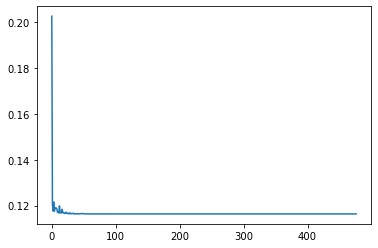

In [74]:
plt.plot(track_loss_sgd)

## SAG

In [75]:
%%time
w = np.copy(starting_point)

track_loss_sag = [loss(data, w, targets)]
track_time_sag = [0]
track_w_sag = [w]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SAG"]
decay = LEARNING_RATE_DECAY["SAG"]

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):

                index = np.random.randint(0, c_data.shape[0])
                g[index] = grad_single(c_data[index], w, c_targets[index])
                grad = np.mean(g, axis=0)
                w = w - step * grad
                step *= decay

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sag.append(w)

        track_time_sag.append(time.time() - start)
        track_loss_sag.append(loss(data, w, targets))

CPU times: user 3min 8s, sys: 6min 22s, total: 9min 30s
Wall time: 1min


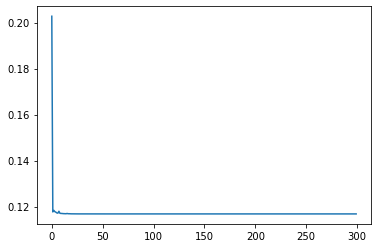

In [76]:
plt.plot(track_loss_sag)

## SAGA

In [77]:
%%time
w = np.copy(starting_point)

track_loss_saga = [loss(data, w, targets)]
track_time_saga = [0]
track_w_saga = [w]

time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SAGA"]

start =  time.time()
decay = LEARNING_RATE_DECAY["SAGA"]

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):

                index = np.random.randint(0, c_data.shape[0])
                gradient = grad_single(c_data[index], w, c_targets[index])
                w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
                g[index] = gradient
                step *= decay

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_saga.append(w)

        track_time_saga.append(time.time() - start)
        track_loss_saga.append(loss(data, w, targets))

CPU times: user 2min 36s, sys: 6min 26s, total: 9min 3s
Wall time: 1min


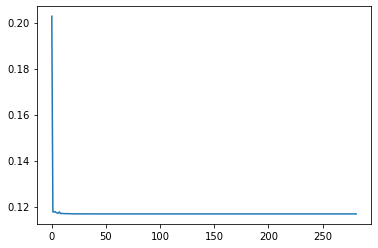

In [78]:
plt.plot(track_loss_saga)

## SVRG

In [79]:
%%time
w = np.copy(starting_point)

track_loss_svrg = [loss(data, w, targets)]
track_time_svrg = [0]
track_angle_svrg = []
track_grad_svrg=[]
track_w_svrg = [w]
track_all_w_svrg=[starting_point]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SVRG"]
decay = LEARNING_RATE_DECAY["SVRG"]

grad_prev = None

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for i, (c_data, c_targets) in enumerate(zip(chunked_data, chunked_target)):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):

                w_tilde = np.copy(w)
                avg_gradients = grad_array(c_data, w, c_targets)
                for j in range(c_data.shape[0] // 16):
                    index = np.random.randint(0, c_data.shape[0])
                    grad = (grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_tilde, c_targets[index]) +
                            avg_gradients)
                    w = w - step * grad
                step *= decay

                track_grad_svrg.append(grad)
                track_all_w_svrg.append(w)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_svrg.append(w)
                if grad_prev is not None:
                    track_angle_svrg.append(angle_between(grad,grad_prev))
                grad_prev = grad

        track_time_svrg.append(time.time() - start)
        track_loss_svrg.append(loss(data, w, targets))

CPU times: user 8min 35s, sys: 46.5 s, total: 9min 21s
Wall time: 1min


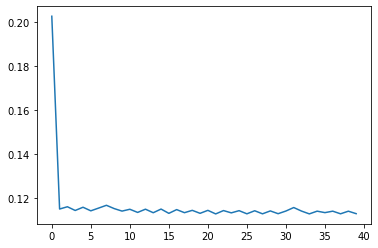

In [80]:
plt.plot(track_loss_svrg)

## SARAH

In [81]:
%%time
w = np.copy(starting_point)

track_loss_sarah = [loss(data, w, targets)]
track_time_sarah = [0]
track_grad_sarah = []
track_angle_sarah = []
track_w_sarah = [w]
track_all_w_sarah = [starting_point]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SARAH"]
decay = LEARNING_RATE_DECAY["SARAH"]

grad_prev = None

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):

                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                for t in range(np.random.randint(0, c_data.shape[0] // 16)):
                    index = np.random.randint(0, c_data.shape[0])
                    v_0 = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_0
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_0
                step *= decay

                track_all_w_sarah.append(w)
                track_grad_sarah.append(v_0)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sarah.append(w)
                if grad_prev is not None:
                    track_angle_sarah.append(angle_between(v_0,grad_prev))
                grad_prev = v_0

        track_time_sarah.append(time.time() - start)
        track_loss_sarah.append(loss(data, w, targets))

CPU times: user 7min 58s, sys: 1min 12s, total: 9min 10s
Wall time: 1min


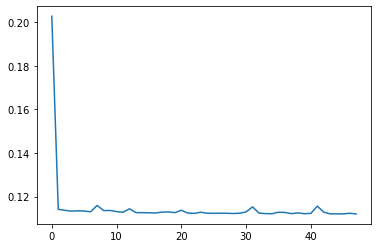

In [82]:
plt.plot(track_loss_sarah)

## SARAH+

In [83]:
%%time
w = np.copy(starting_point)

track_loss_sarah_plus = [loss(data, w, targets)]
track_time_sarah_plus = [0]
track_w_sarah_plus = [w]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SARAH+"]
decay = LEARNING_RATE_DECAY["SARAH+"]

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):

                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                v_t = np.copy(v_0)
                for t in range(c_data.shape[0] // 16):
                    if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
                        break
                    index = np.random.randint(0, c_data.shape[0])
                    v_t = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_t
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_t
                step *= decay

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sarah_plus.append(w)

        track_time_sarah_plus.append(time.time() - start)
        track_loss_sarah_plus.append(loss(data, w, targets))

CPU times: user 9min 14s, sys: 17.1 s, total: 9min 31s
Wall time: 1min


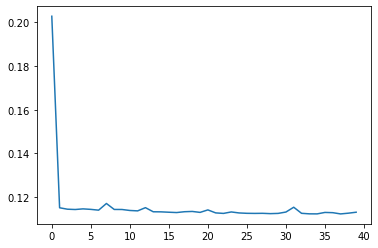

In [84]:
plt.plot(track_loss_sarah_plus)

## SpiderBoost

In [85]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_spider_boost = [loss(data, w, targets)]
track_time_spider_boost = [0]
track_angle_spider_boost = []
track_grad_spider_boost = []
track_w_spider_boost = [w]
track_all_w_spider_boost = [starting_point]

time_counter = time.time()
start =  time.time()

step = STEP_SIZES[DATASET][LOSS]["SpiderBoost"]
decay = LEARNING_RATE_DECAY["SpiderBoost"]

grad_prev = None

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            all_indexes = list(range(c_data.shape[0]))
            v_previous = grad_array(c_data, w, c_targets)
            for i in range(ITERS_PER_BATCH):

                q = int(math.sqrt(c_data.shape[0]))
                if  i % q == 0:
                    vk = grad_array(c_data, w, c_targets)
                else:
                    sample_indexes = np.random.choice(all_indexes, q)
                    samples_data = c_data[sample_indexes]
                    samples_targets = c_targets[sample_indexes]

                    first = grad_array(samples_data, w, samples_targets)
                    second = grad_array(samples_data, w_previous, samples_targets)
                    vk = (first - second) + v_previous
                w_previous = np.copy(w)
                v_previous = np.copy(vk)
                w = w - step * vk
                step *= decay

                track_all_w_spider_boost.append(w_previous)
                track_grad_spider_boost.append(vk)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_spider_boost.append(w)
                if grad_prev is not None:
                    track_angle_spider_boost.append(angle_between(vk,grad_prev))
                grad_prev = vk

        track_time_spider_boost.append(time.time() - start)
        track_loss_spider_boost.append(loss(data, w, targets))

CPU times: user 8min 37s, sys: 56.5 s, total: 9min 33s
Wall time: 1min
Parser   : 1.05 s


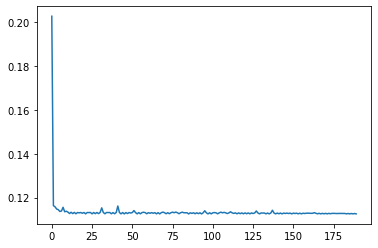

In [86]:
plt.plot(track_loss_spider_boost)

## SNVRG

In [87]:
def updateReferencePoints(wl_old, w, r, K):
    wl_new  = []
    for l in range(r):
        wl_new.append(wl_old[l])
    for l in range(r, K+1):
        wl_new.append(w)
    return np.array(wl_new)

def updateReferenceGradients(gl_old, wl_new, r, K, Bl, data, targets):
    gl_new  = []
    for l in range(r):
        gl_new.append(gl_old[l])
    for l in range(r, K+1):
        indexes = np.random.choice(list(range(data.shape[0])), Bl[l], replace=False)
        gl_new.append(grad_array(data[indexes], wl_new[l], targets[indexes]) -
                      grad_array(data[indexes], wl_new[l-1], targets[indexes]))
    return gl_new
rs = []
def oneEpochSNVRG(w, M, data, targets):
    w = np.copy(w)
    K = 2
    B = 256
    b = 2
    Bl = np.array([B/(b**(i+1)) for i in range(K+1)]).astype("int")
    Tl = np.array([b for _ in range(K+1)])
    wl = np.array([w for _ in range(K+1)])
    wl_history = [[w for _ in range(K+1)]]
    gl = np.array([np.zeros(np.shape(w)).tolist() for _ in range(K+1)])
    indexes = np.random.choice(list(range(data.shape[0])), B, replace=False)
    gl[0] = grad_array(data[indexes], w, targets[indexes])
    v = np.sum(gl, axis=0)
    w = w - 1/(10 * M) * v
    wl_history.append(np.copy(w))
    for t in range(1, np.prod(Tl) - 1):

        for j in range( K + 1):
            if t % np.prod(Tl[j+1:]) == 0:
                r = j
                break
        r = max(1, r)
        rs.append(r)

        wl = updateReferencePoints(wl, w, r, K)
        gl = updateReferenceGradients(gl, wl, r, K, Bl, data, targets)

        v = np.sum(gl, axis=0)

        w = w - 1/(10 * M) * v
        wl_history.append(np.copy(w))

    return wl_history[np.random.randint(wl.shape[0] - 1)], w, v

In [88]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_snvrg = [loss(data, w, targets)]
track_time_snvrg = [0]
track_angle_snvrg = []
track_grad_snvrg = []
track_w_snvrg = [w]
track_all_w_snvrg = [starting_point]

time_counter = time.time()
start =  time.time()

M = STEP_SIZES[DATASET][LOSS]["SNVRG"]
decay = LEARNING_RATE_DECAY["SNVRG"]

grad_prev = None

# loop over epochs
for i in range(EPOCHS):
    # if MAX_RUNTIME > time passed, stop
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    # over the dataset 2 times per epochs
    for j in range(2):
        # if MAX_RUNTIME > time passed, stop
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        # set seed if SAME_MINI_BATCH, in order to have different batches every iterations
        # but same batches if runned again
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):

                y_s, w, grad = oneEpochSNVRG(w, M, c_data, c_targets)
                M /= decay

                track_all_w_snvrg.append(w)
                track_grad_snvrg.append(grad)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_snvrg.append(w)
                if grad_prev is not None:
                    track_angle_snvrg.append(angle_between(grad,grad_prev))
                grad_prev = np.copy(grad)

        track_time_snvrg.append(time.time() - start)
        track_loss_snvrg.append(loss(data, w, targets))

CPU times: user 7min 45s, sys: 1min 24s, total: 9min 10s
Wall time: 1min


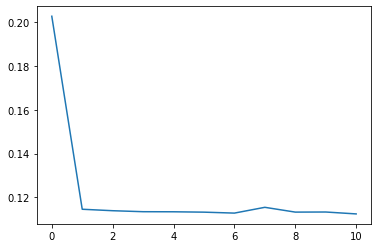

In [89]:
plt.plot(track_loss_snvrg)

In [90]:
%%time
# PL implementation
if False:
    w = np.copy(starting_point)
    w_previous = np.zeros(data.shape[1])

    track_loss_snvrg_pl = [loss(data, w, targets)]
    track_time_snvrg_pl = [0]
    track_w_snvrg_pl = [w]
    time_counter = time.time()
    start =  time.time()
    M = STEP_SIZES[DATASET][LOSS]["SNVRG"]
    decay = LEARNING_RATE_DECAY["SNVRG"]

    for i in range(EPOCHS):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        for _ in range(2):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            chunked_data, chunked_target = getMiniBatch()
            for c_data, c_targets in zip(chunked_data, chunked_target):
                if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
                for _ in range(ITERS_PER_BATCH // 10):
                    for _ in range(np.random.randint(0, ITERS_PER_BATCH)):
                        y_s, w = oneEpochSNVRG(w, M, c_data, c_targets)

                        M /= decay
                        if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                            time_counter = time.time()
                            track_w_snvrg_pl.append(w)
            track_time_snvrg_pl.append(time.time() - start)
            track_loss_snvrg_pl.append(loss(data, w, targets))

CPU times: user 7 µs, sys: 25 µs, total: 32 µs
Wall time: 8.82 µs


## Plots

In [121]:
# convert everything (lists) to np arrays
track_time_sgd = np.array(track_time_sgd)
track_time_sag = np.array(track_time_sag)
track_time_saga = np.array(track_time_saga)
track_time_sarah = np.array(track_time_sarah)
track_time_sarah_plus = np.array(track_time_sarah_plus)
track_time_spider_boost = np.array(track_time_spider_boost)
track_time_svrg = np.array(track_time_svrg)
track_time_snvrg = np.array(track_time_snvrg)

track_loss_sgd = np.array(track_loss_sgd)
track_loss_sag = np.array(track_loss_sag)
track_loss_saga = np.array(track_loss_saga)
track_loss_sarah = np.array(track_loss_sarah)
track_loss_sarah_plus = np.array(track_loss_sarah_plus)
track_loss_spider_boost = np.array(track_loss_spider_boost)
track_loss_svrg = np.array(track_loss_svrg)
track_loss_snvrg = np.array(track_loss_snvrg)

In [122]:
# In case we want plots using time, we consider only the updates in the MAX-TIME interval
if PLOT_TIME:
    track_loss_sgd = track_loss_sgd[track_time_sgd < MAX_RUNTIME]
    track_loss_sag = track_loss_sag[track_time_sag < MAX_RUNTIME]
    track_loss_saga = track_loss_saga[track_time_saga < MAX_RUNTIME]
    track_loss_sarah = track_loss_sarah[track_time_sarah < MAX_RUNTIME]
    track_loss_sarah_plus = track_loss_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
    track_loss_spider_boost = track_loss_spider_boost[track_time_spider_boost < MAX_RUNTIME]
    track_loss_svrg = track_loss_svrg[track_time_svrg < MAX_RUNTIME]
    track_loss_snvrg = track_loss_snvrg[track_time_snvrg < MAX_RUNTIME]

    track_time_sgd = track_time_sgd[track_time_sgd < MAX_RUNTIME]
    track_time_sag = track_time_sag[track_time_sag < MAX_RUNTIME]
    track_time_saga = track_time_saga[track_time_saga < MAX_RUNTIME]
    track_time_sarah = track_time_sarah[track_time_sarah < MAX_RUNTIME]
    track_time_sarah_plus = track_time_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
    track_time_spider_boost = track_time_spider_boost[track_time_spider_boost < MAX_RUNTIME]
    track_time_svrg = track_time_svrg[track_time_svrg < MAX_RUNTIME]
    track_time_snvrg = track_time_snvrg[track_time_snvrg < MAX_RUNTIME]

In [123]:
# finding the minimum found by every algorithms
min = np.min(
    np.concatenate((
        track_loss_sarah,
        track_loss_sarah_plus,
        track_loss_snvrg,
        track_loss_sag,
        track_loss_saga,
        track_loss_snvrg,
        track_loss_spider_boost,
        track_loss_sgd,
    ))
)

In [124]:
# Finding the best guess of F(x*)
# might happend that an algorithm finds a better approximation
# causing the F-F* to be negative, using F*=MIN
min = np.min((min, MIN))

In [125]:
min_iters = np.min(
    [
        len(track_loss_sgd),
        len(track_loss_sag),
        len(track_loss_saga),
        len(track_loss_svrg),
        len(track_loss_sarah),
        len(track_loss_sarah_plus),
        len(track_loss_spider_boost),
        len(track_loss_snvrg),
    ]
)

### Iterations

$log(F-F^*)$ against iterations

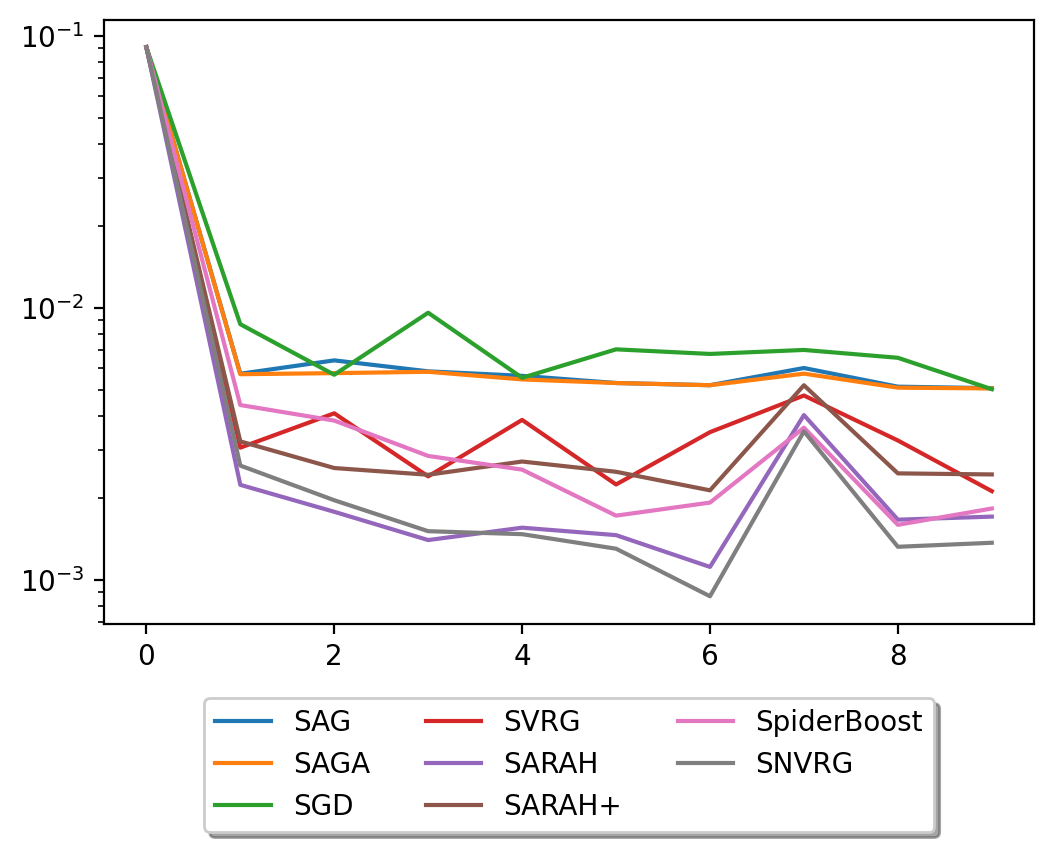

In [126]:
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_loss_sag[:min_iters] - min)
plt.semilogy(track_loss_saga[:min_iters] - min)
plt.semilogy(track_loss_sgd[:min_iters] - min)
plt.semilogy(track_loss_svrg[:min_iters] - min)
plt.semilogy(track_loss_sarah[:min_iters] - min)
plt.semilogy(track_loss_sarah_plus[:min_iters] - min)
plt.semilogy(track_loss_spider_boost[:min_iters] - min)
plt.semilogy(track_loss_snvrg[:min_iters] - min)

plt.legend([ "SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

$F-F^*$ against iterations

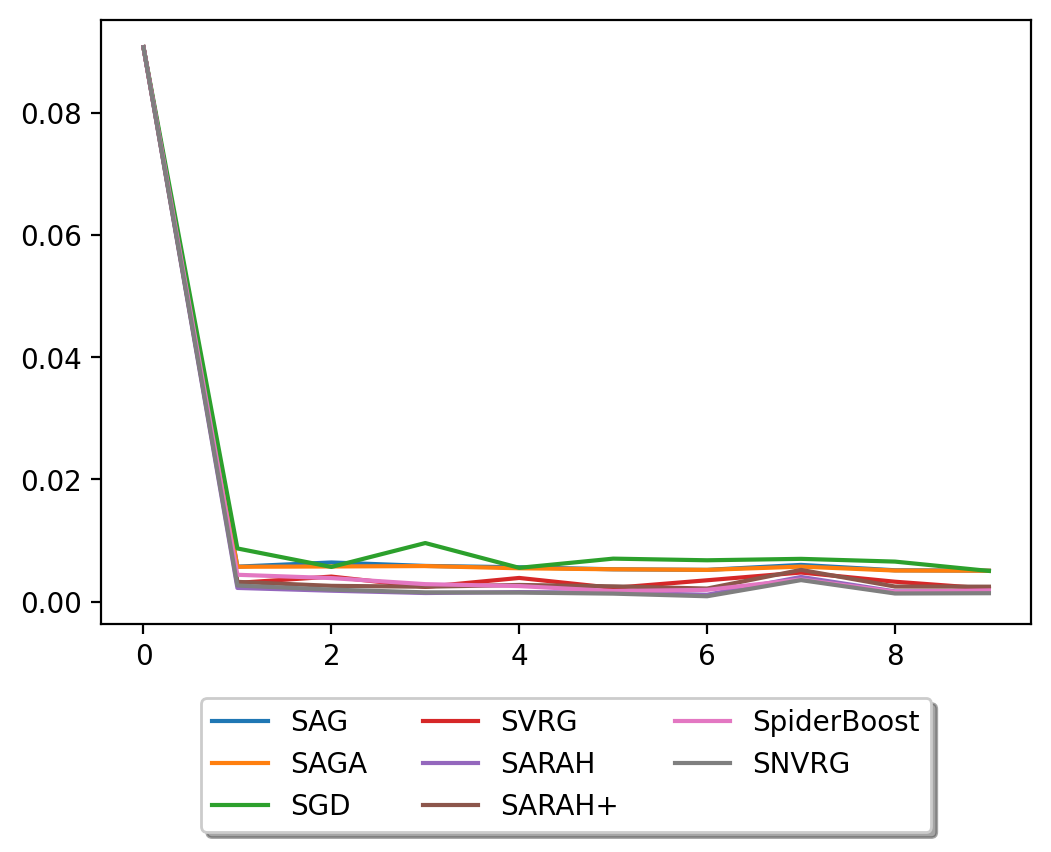

In [127]:
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_loss_sag[:min_iters] - min)
plt.plot(track_loss_saga[:min_iters] - min)
plt.plot(track_loss_sgd[:min_iters] - min)
plt.plot(track_loss_svrg[:min_iters] - min)
plt.plot(track_loss_sarah[:min_iters] - min)
plt.plot(track_loss_sarah_plus[:min_iters] - min)
plt.plot(track_loss_spider_boost[:min_iters] - min)
plt.plot(track_loss_snvrg[:min_iters] - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Time

$log(F-F^*)$ against time

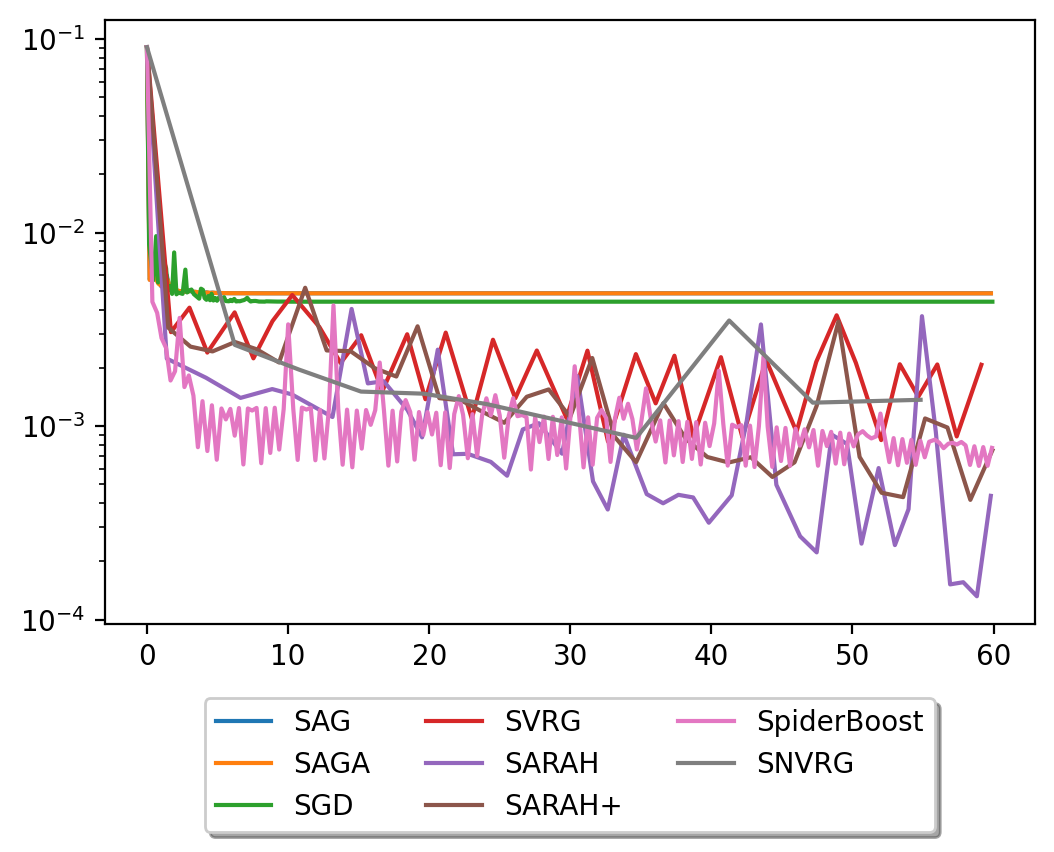

In [97]:
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_loss_sag - min)
plt.semilogy(track_time_saga, track_loss_saga - min)
plt.semilogy(track_time_sgd, track_loss_sgd - min)
plt.semilogy(track_time_svrg, track_loss_svrg - min)
plt.semilogy(track_time_sarah, track_loss_sarah - min)
plt.semilogy(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.semilogy(track_time_spider_boost, track_loss_spider_boost - min)
plt.semilogy(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

$F-F^*$ against time

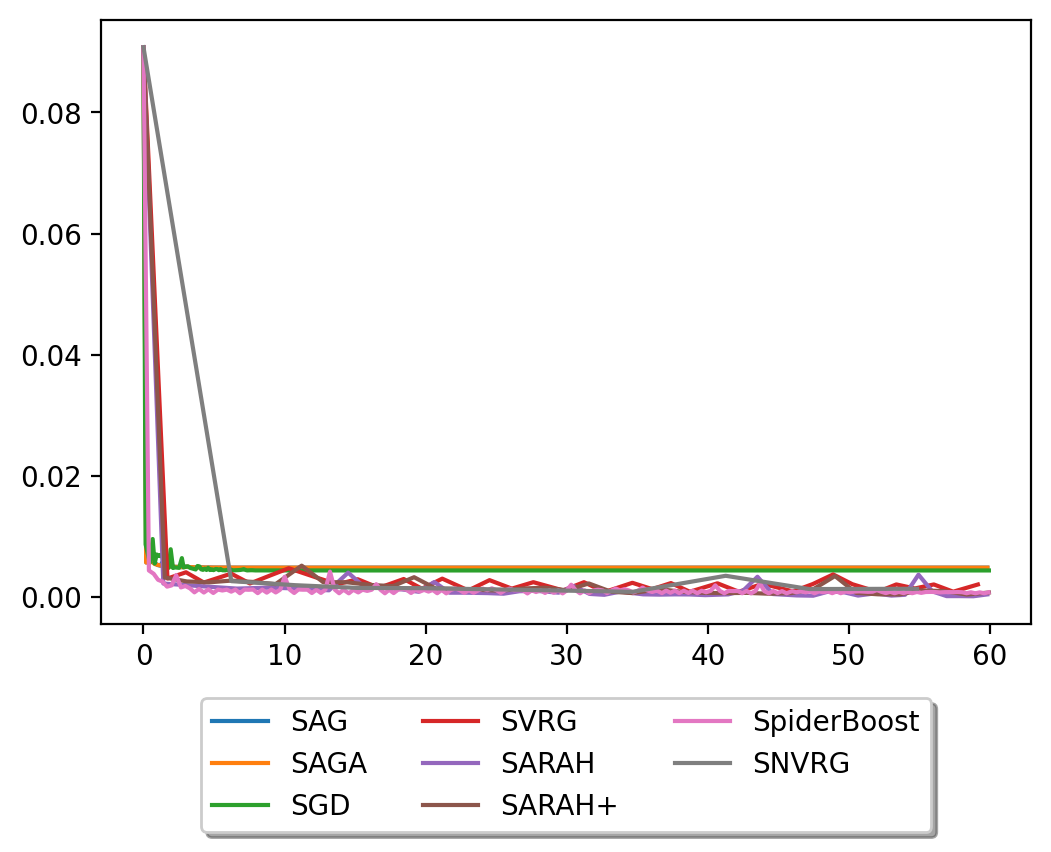

In [98]:
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_loss_sag - min)
plt.plot(track_time_saga, track_loss_saga - min)
plt.plot(track_time_sgd, track_loss_sgd - min)
plt.plot(track_time_svrg, track_loss_svrg - min)
plt.plot(track_time_sarah, track_loss_sarah - min)
plt.plot(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.plot(track_time_spider_boost, track_loss_spider_boost - min)
plt.plot(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Angle between gradients

Angle between gradients, the less "noisy" the plot, the less "noisy" the estimator

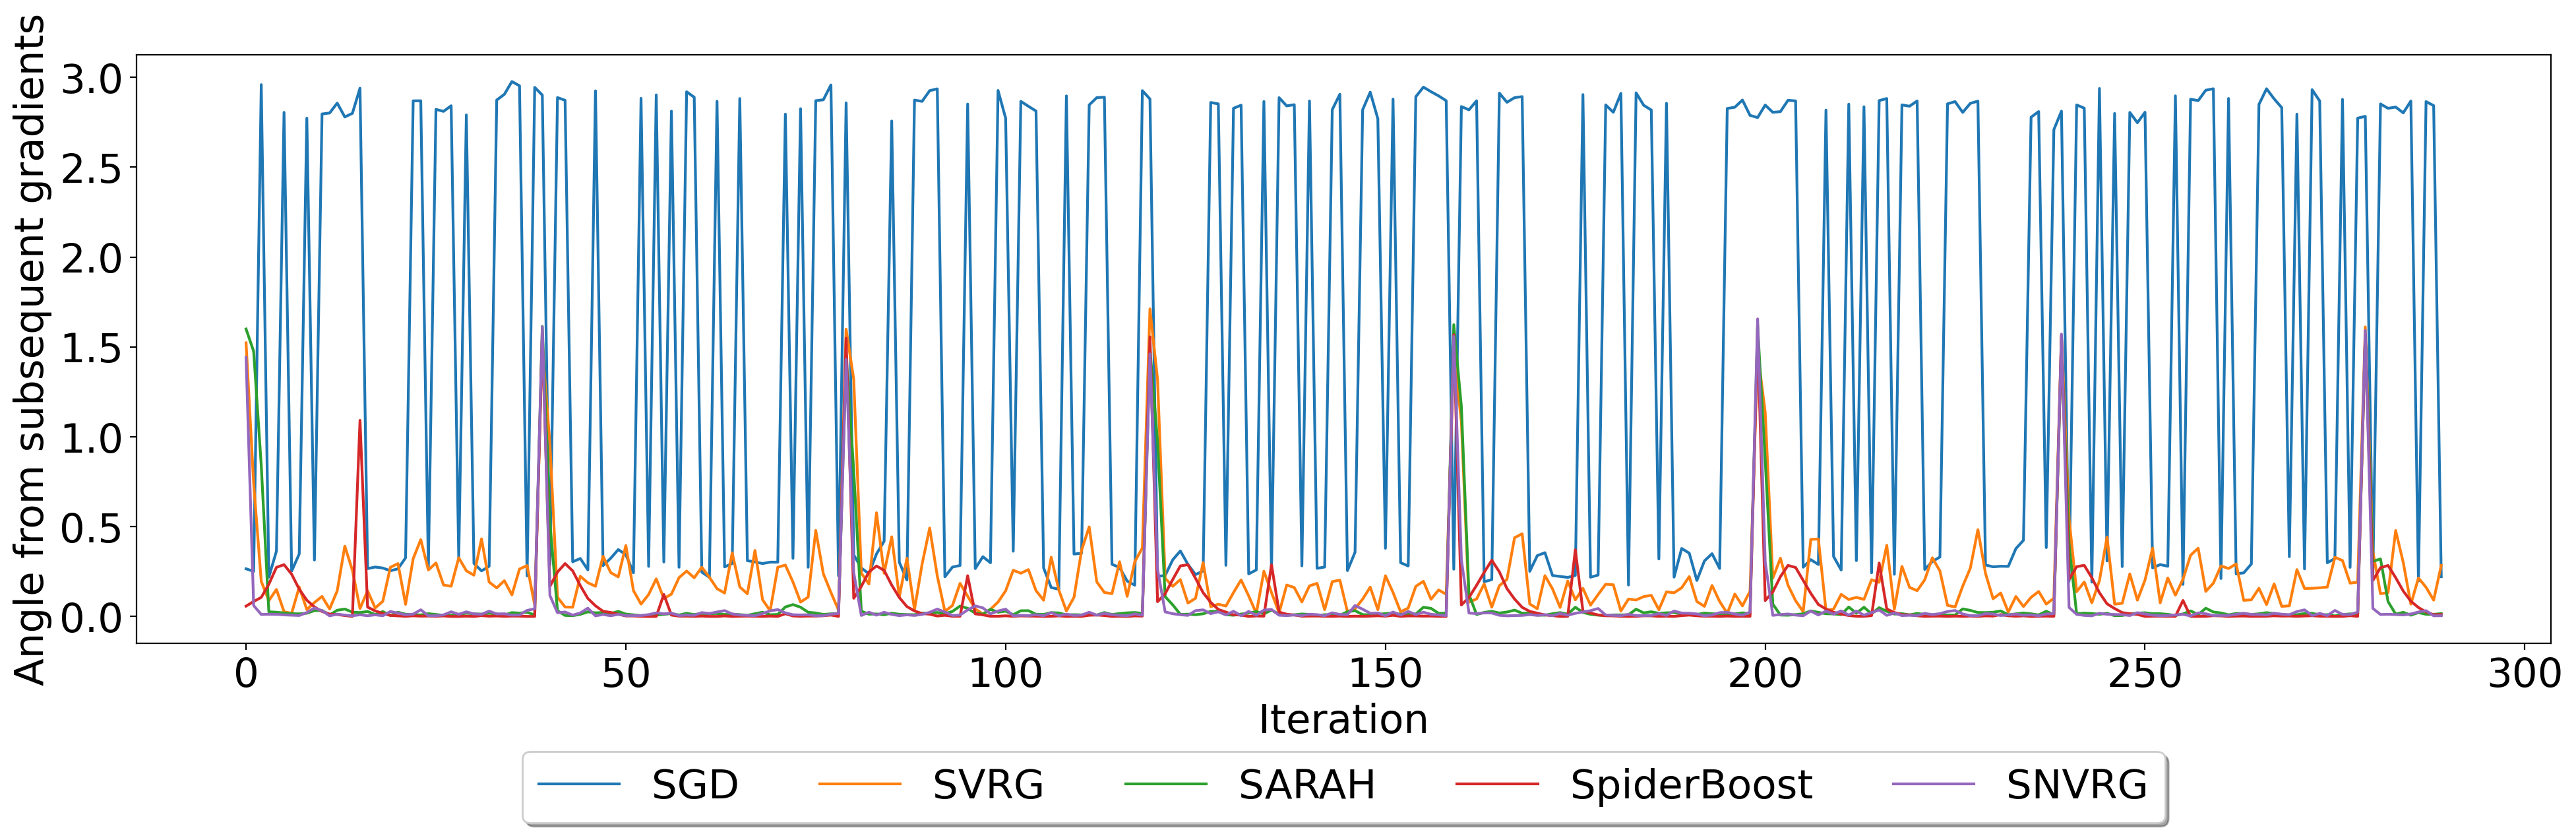

In [99]:
plt.figure(figsize=(60/2.54, 15/2.54), dpi=DPI_PLOTS)
#plt.ylim(0, 0.5)
plt.rcParams.update({'font.size': 22})
N = 290
plt.plot(track_angle_sgd[:N])
plt.plot(track_angle_svrg[:N])
plt.plot(track_angle_sarah[:N])
plt.plot(track_angle_spider_boost[:N])
plt.plot(track_angle_snvrg[:N])
plt.xlabel("Iteration")
plt.ylabel("Angle from subsequent gradients")

plt.legend(["SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)
plt.show()
plt.rcParams.update({'font.size': 10})

### Gradient error

Gradient error, comparing the estimated gradient with the correct one (calculated on the minibatch), $||\nabla f_i(x_k) - \nabla F(x_k)||^2$

In [100]:
%%time
TO = 480
MEAN_EACH = 4
real_grad_sgd_error = []
real_grad_svrg_error = []
real_grad_sarah_error = []
real_grad_spider_boost_error = []
real_grad_snvrg_error = []
flag = False
# to calculate the gradient on the correct minibatch, we do the same
# as we did for the algorithms, using the same seed

# over the epochs
for i in range(EPOCHS):
    if flag: break
    # over the minibatches 2 times per epochs
    for j in range(2):
        if flag: break
        # set the seed to have the same minibatches as in the algorithms
        np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for n, (c_data, c_targets) in enumerate(zip(chunked_data, chunked_target)):
            if flag: break
            for iter in range(ITERS_PER_BATCH):
                if flag: break
                # calculate the number of update
                index = (
                        i * 2 * len(chunked_target) * ITERS_PER_BATCH +
                        j * len(chunked_target) * ITERS_PER_BATCH +
                        n * ITERS_PER_BATCH +
                        iter
                )
                # stop if we reach the desider number of iterations
                if index == TO:
                    flag = True
                    break
                # norm between the calculated/estimated gradient and the correct one
                # (scaled ot unit vectors to avoid problem with biased estimators)
                real_grad_sgd_error.append(
                    np.linalg.norm(
                        unit_vector(grad_array(c_data, track_all_w_sgd[index], c_targets)) -
                        unit_vector(track_grad_sgd[index]))
                )
                # norm between the calculated/estimated gradient and the correct one
                # (scaled ot unit vectors to avoid problem with biased estimators)
                real_grad_svrg_error.append(
                    np.linalg.norm(
                        unit_vector(grad_array(c_data, track_all_w_svrg[index], c_targets)) -
                        unit_vector(track_grad_svrg[index]))
                )

                # norm between the calculated/estimated gradient and the correct one
                # (scaled ot unit vectors to avoid problem with biased estimators)
                real_grad_sarah_error.append(
                    np.linalg.norm(
                        unit_vector(grad_array(c_data, track_all_w_sarah[index], c_targets)) -
                        unit_vector(track_grad_sarah[index]))
                )
                # norm between the calculated/estimated gradient and the correct one
                # (scaled ot unit vectors to avoid problem with biased estimators)
                real_grad_spider_boost_error.append(
                    np.linalg.norm(
                        unit_vector(grad_array(c_data, track_all_w_spider_boost[index], c_targets)) -
                        unit_vector(track_grad_spider_boost[index]))
                )
                # norm between the calculated/estimated gradient and the correct one
                # (scaled ot unit vectors to avoid problem with biased estimators)
                real_grad_snvrg_error.append(
                    np.linalg.norm(unit_vector(
                        grad_array(c_data, track_all_w_snvrg[index], c_targets)) -
                                   unit_vector(track_grad_snvrg[index]))
                )

real_grad_sgd_error = np.array(real_grad_sgd_error).reshape((MEAN_EACH, -1)).mean(axis=0)
real_grad_svrg_error = np.array(real_grad_svrg_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_svrg_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0
real_grad_sarah_error = np.array(real_grad_sarah_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_sarah_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0
real_grad_spider_boost_error = np.array(real_grad_spider_boost_error).reshape((MEAN_EACH, -1)).mean(axis=0)
real_grad_snvrg_error = np.array(real_grad_snvrg_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_snvrg_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0


CPU times: user 8.15 s, sys: 1.39 s, total: 9.54 s
Wall time: 1.1 s


In [101]:
plt.rcParams.update({'font.size': 22})

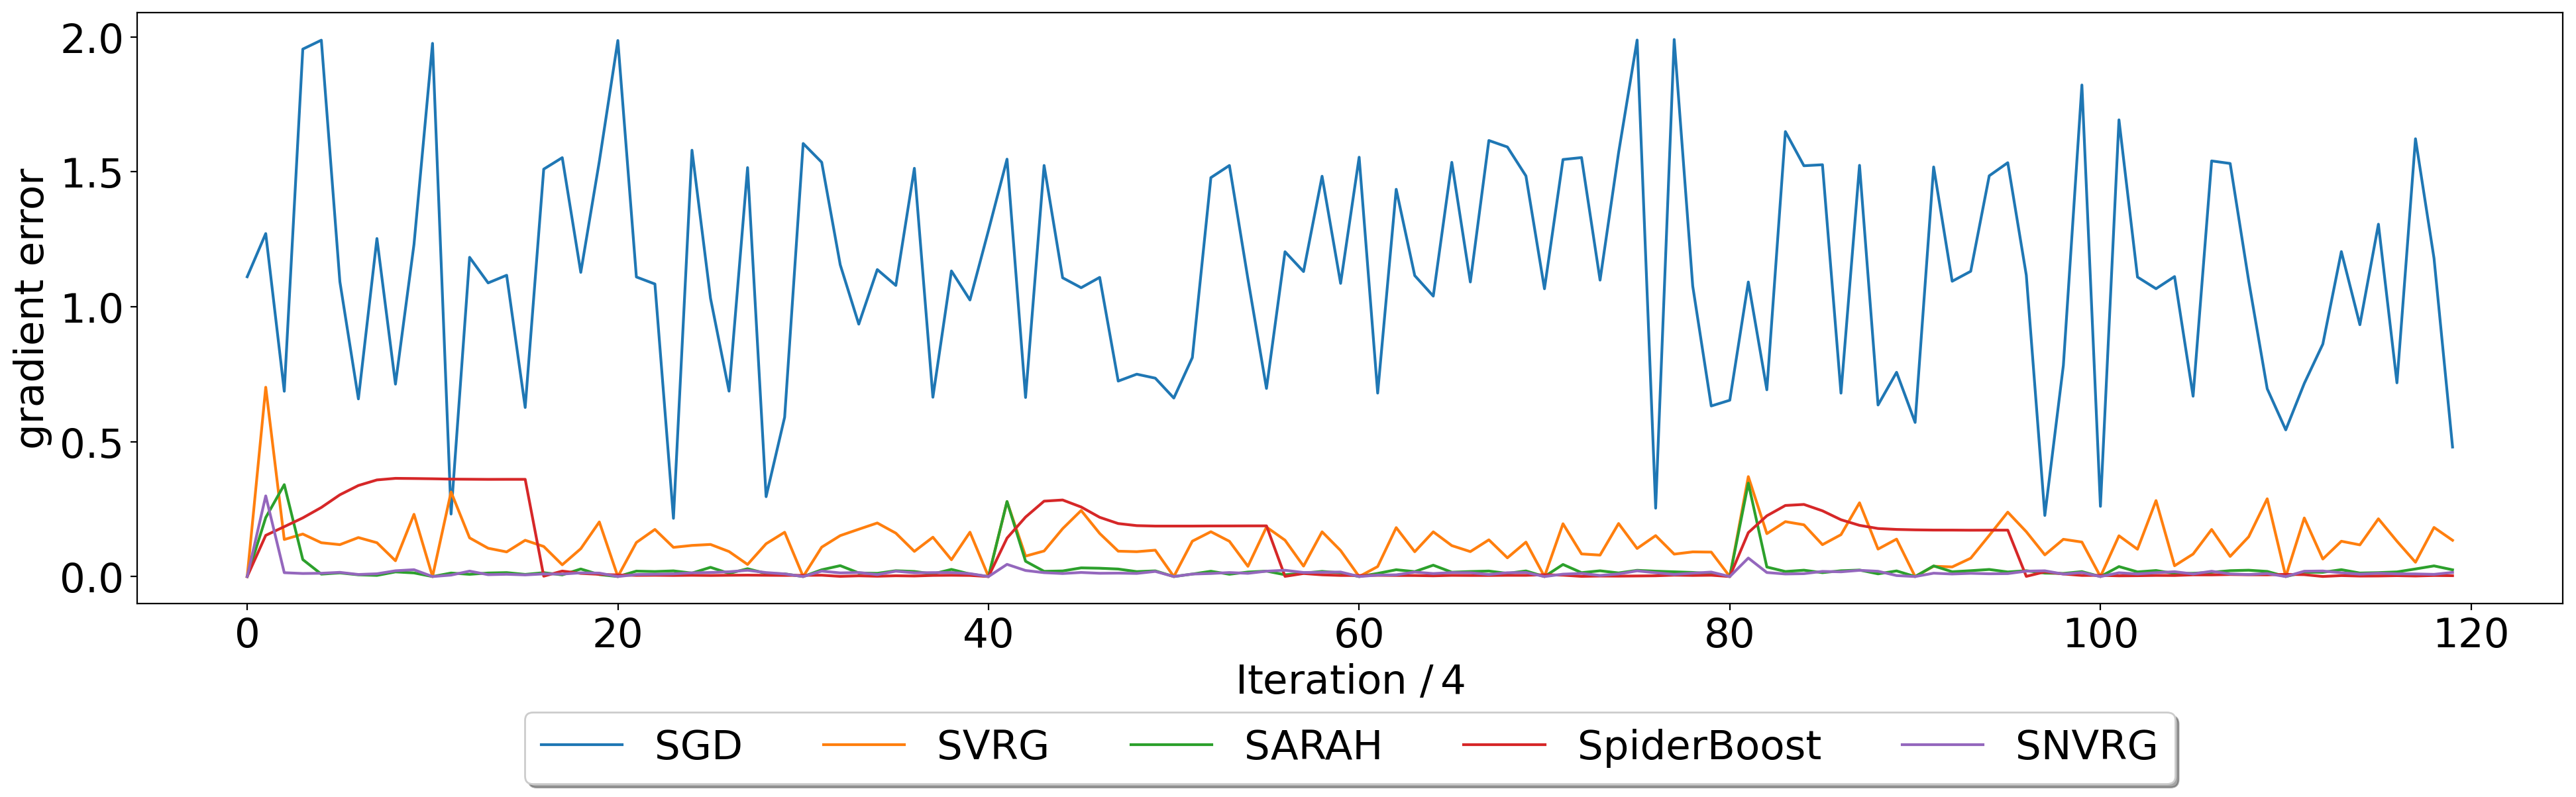

In [102]:
plt.figure(figsize=(60/2.54, 15/2.54), dpi=DPI_PLOTS)
#plt.ylim(0,0.5)
plt.rcParams.update({'font.size': 22})
plt.plot(real_grad_sgd_error)
plt.plot(real_grad_svrg_error)
plt.plot(real_grad_sarah_error)
plt.plot(real_grad_spider_boost_error)
plt.plot(real_grad_snvrg_error)
plt.xlabel(f"Iteration $/ \,{MEAN_EACH}$")
plt.ylabel("gradient error")

plt.legend(["SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)
plt.show()
plt.rcParams.update({'font.size': 10})

Calculate the mean of the estimated errors, $\frac{1}{n}\sum_{k=0}^n||\nabla f_i(x_k) - \nabla F(x_k)||^2$

In [103]:
mean_sgd = real_grad_sgd_error.mean()
mean_svrg = real_grad_svrg_error.mean()
mean_sarah = real_grad_sarah_error.mean()
mean_spider_boost = real_grad_spider_boost_error.mean()
mean_snvrg = real_grad_snvrg_error.mean()

print(f"""SGD: {mean_sgd:.3f}
SVRG: {mean_svrg:.3f}
SARAH: {mean_sarah:.3f}
SpiderBoost: {mean_spider_boost:.3f}
SNVRG: {mean_snvrg:.3f}""")

SGD: 1.132
SVRG: 0.127
SARAH: 0.027
SpiderBoost: 0.092
SNVRG: 0.015


Graphical representation of the different estimated variances

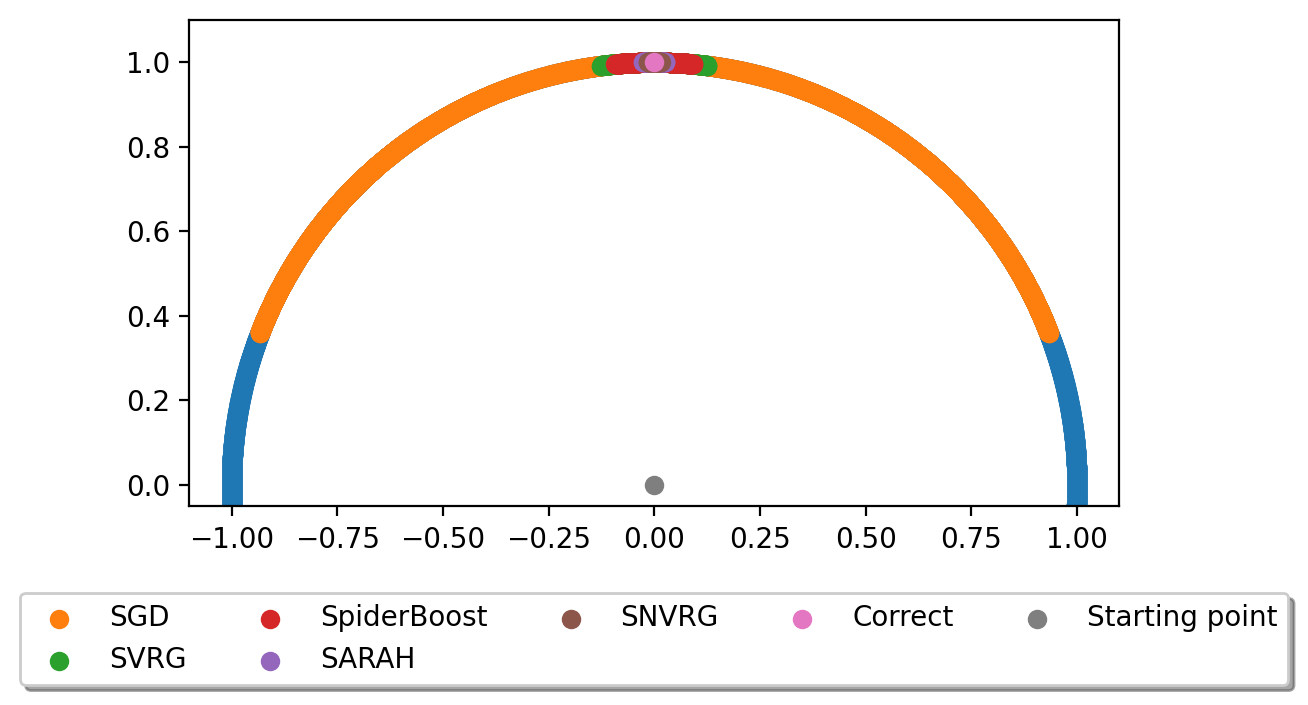

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def circle_points(r, n):
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.c_[x, y]

points = np.array(circle_points(1, 10000))

fig, ax = plt.subplots(dpi=DPI_PLOTS)
ax.set_aspect('equal')
ax.scatter(points[:,0], points[:,1], label='_nolegend_')

for mean in [mean_sgd, mean_svrg, mean_spider_boost, mean_sarah, mean_snvrg]:
    p_in_error = np.array([point for point in points if np.linalg.norm(point - np.array([0,1])) < mean])
    ax.scatter(p_in_error[:,0], p_in_error[:,1])
ax.set_ylim(-0.05,1.1)
ax.scatter([0], [1])
ax.scatter([0], [0])
plt.legend(["SGD", "SVRG", "SpiderBoost", "SARAH", "SNVRG", "Correct", "Starting point"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)

### Contour plots of main algorithms

In [105]:
def generate(w, PAD=1, TITLE=""):
    w_cut = w[:10000]

    X = np.linspace(-25, 50, 100)
    Y = np.linspace(-10, 80, 100)
    Z = []
    # for each pair of x,y we calculate the loss for the contour plot
    for y in Y:
        Z.append([loss(data, np.array([x, y]), targets) for x in X])

    # create the contour plot and the scatter with the calculated points x_k
    fig = go.Figure(
        data =[
        go.Contour(
            z=Z,
            x=X,
            y=Y,
            showscale=False,
        ),
        go.Scatter(
            showlegend = False,
            hoverinfo='none',
            x=np.array(w_cut)[:,0],
            y=np.array(w_cut)[:,1],
            mode='markers+lines',
            marker=dict(
                size=4,
                color="#ff4747",
                colorscale='Viridis',
            ),
            line=dict(
                color="#ff4747",
                width=2
            )
        )
    ])
    fig.update_layout(
        title={
            'text': TITLE,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.update_traces(ncontours=45, selector=dict(type='contour'))
    fig.update_xaxes(range=[-25, 50])
    fig.update_yaxes(range=[-10, 80])
    fig.update_layout(
        width=500,height=500,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual',
        ),
    )
    fig.show(renderer="browser")

In [106]:
# generate contour plot for each algorithm
if SHOW_ANIMATION and data.shape[1] == 2:
    generate(track_all_w_sgd, TITLE="SGD")
    generate(track_all_w_sarah, TITLE="SARAH")
    generate(track_all_w_snvrg, TITLE="SNVRG")
    generate(track_all_w_spider_boost, TITLE="SpiderBoost")
    generate(track_all_w_svrg, TITLE="SVRG")


## 3D plots

### Animated

In [107]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    x_range = (-30,80)
    y_range = (-30,80)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    X, Y = np.meshgrid(x, y)
    # calculate the loss for the 3D surface
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    tracks = [
        track_w_sgd, track_w_svrg,
        track_w_sarah, track_w_spider_boost, track_w_snvrg
    ]
    names = [
        "SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"
    ]

    frames_tot = np.min([
        len(t) for t in tracks
    ])
    surface = go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),

    frames = []
    # for each point estimated by the algorithm, we create a frame
    for frame in range(frames_tot):
        grid = []
        #generate horizontal scatter plot for grid:
        for idx, x_ in enumerate(x):
            grid.append(
                go.Scatter3d(
                    x=[x_] * (len(y)), y=y, z=Z[:,idx],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )
        #generate vertical scatter plot: for grid
        for idx, y_ in enumerate(y):
            grid.append(
                go.Scatter3d(
                    x=x, y=[y_] * (len(x)), z=Z[idx,:],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )
        # we add the surface of the loss
        frame_data = grid + [
            go.Surface(
                showscale=False,
                z=Z, x=X, y=Y,
                colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
                colorbar=None
            )
        ]
        # for each algorithm, we add a scatter with the estimated points x_k up to now
        for i, (track, name) in enumerate(zip(tracks, names)):
            track = track[:frame]
            xx, yy = np.hsplit(np.array(track),2)
            zz = np.array([loss(data, w_, targets) for w_ in track])
            xx = xx.reshape(-1)
            yy = yy.reshape(-1)
            zz = zz.reshape(-1)
            color = int(i/len(tracks)*255)
            frame_data.append(
                go.Scatter3d(
                    name=name,
                    x=xx, y=yy, z=zz,
                    marker=dict(
                        size=4,
                        color=f"hsl({color}, 100%, 50%)",
                        colorscale='Viridis',
                    ),
                    line=dict(
                        color=f"hsl({color}, 100%, 50%)",
                        width=2
                    )
                )
            )
        frames.append(go.Frame(data=frame_data)) #1

    fig = go.Figure(data=frames[0].data, frames=frames)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(args = [],
                          label = "Play",
                          method = "animate")]
        )]
    )

    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)


    fig.show(renderer="browser")
    del fig


    #USED TO FIND CAMERA
    # import plotly.graph_objects as go
    # import dash
    # import dash_core_components as dcc
    # import dash_html_components as html
    # from dash.dependencies import Input, Output
    # app = dash.Dash()
    # app.layout = html.Div([
    #     html.Div(id="output"),        # use to print current relayout values
    #     dcc.Graph(id="fig", figure=fig)
    # ])
    # @app.callback(
    #     Output("output", "children"),
    #     Input("fig", "relayoutData")
    # )
    # def show_data(data):
    #     # show camera settings like eye upon change
    #     return [str(data)]
    # app.run_server(debug=False, use_reloader=False)

### Static first N

In [108]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    NUM_POINTS = 500
    FIRST_N = 1000
    x_range = (-30,80)
    y_range = (-30,80)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    X, Y = np.meshgrid(x, y)
    # calculate the loss
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    tracks = [track[:FIRST_N][::int(len(track[:FIRST_N]) / 500)] for track in [
        track_all_w_sgd, track_all_w_svrg,
        track_all_w_sarah, track_all_w_spider_boost, track_all_w_snvrg
    ]]

    names = [
        "SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"
    ]

    surface = go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),

    grid = []
    #generate horizontal scatter plot for grid:
    for idx, x_ in enumerate(x):
        grid.append(
            go.Scatter3d(
                x=[x_] * (len(y)), y=y, z=Z[:,idx],
                mode="lines",
                showlegend=False,
                line=dict(
                    color=f"rgb(200,200,200)",
                    width=2
                )
            )
        )
    #generate vertical scatter plot for grid:
    for idx, y_ in enumerate(y):
        grid.append(
            go.Scatter3d(
                x=x, y=[y_] * (len(x)), z=Z[idx,:],
                mode="lines",
                showlegend=False,
                line=dict(
                    color=f"rgb(200,200,200)",
                    width=2
                )
            )
        )


    # we add the surface of the loss
    data_ = grid + [
        go.Surface(
            showscale=False,
            z=Z, x=X, y=Y,
            colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
            colorbar=None
        )
    ]
    # for each algorithm, we add a scatter with the first N x_k calculated by it
    for i, (track, name) in enumerate(zip(tracks, names)):
        xx, yy = np.hsplit(np.array(track),2)
        zz = np.array([loss(data, w_, targets) for w_ in track])
        xx = xx.reshape(-1)
        yy = yy.reshape(-1)
        zz = zz.reshape(-1)
        color = int(i/len(tracks)*255)
        data_.append(
            go.Scatter3d(
                name=name,
                x=xx, y=yy, z=zz,
                marker=dict(
                    size=4,
                    color=f"hsl({color}, 100%, 50%)",
                    colorscale='Viridis',
                ),
                line=dict(
                    color=f"hsl({color}, 100%, 50%)",
                    width=2
                )
            )
        )


    fig = go.Figure(data=data_)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(args = [],
                          label = "Play",
                          method = "animate")]
        )]
    )

    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)


    fig.show(renderer="browser")
    del fig